# Model to ICEWS Events

This analysis uses the updated (non-replication) agents.

In [1]:
import copy
import pickle
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, permutations


import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Model_Output:
    def __init__(self, model):
        '''
        Store data from model run.
        '''
        self.agent_vars = model.datacollector.get_agent_vars_dataframe()
        self.model_vars = model.datacollector.get_model_vars_dataframe()
        self.log = model.log


In [3]:
agents = pd.read_csv("ICEWS_2004_agents.csv")

In [4]:
with open("data_output/ICEWS_Ex4_1.pickle", "rb") as f:
    all_models = pickle.load(f)

In [5]:
conflict_dyads = Counter()
conflict_models = defaultdict(set)

for i, model in enumerate(all_models):
    for event in model.log.get_events(action="Attack"):
        source = event.source
        target = event.target
        dyad = (source, target)
        conflict_dyads[dyad] += 1
        conflict_models[dyad].add(i)

conflict_models = {k: len(v) for k, v in conflict_models.items()}        
        
# Fill in zeroes
actors = agents.Name.unique()
for source, target in permutations(actors, 2):
    dyad = (source, target)
    if dyad not in conflict_dyads:
        conflict_dyads[dyad] = 0
    if dyad not in conflict_models:
        conflict_models[dyad] = 0

## Get ICEWS Data

Data prepared in [6.05 ICEWS Aggregation](http://localhost:8888/notebooks/Programming/ConflictModel/negotiation_model/6.05%20ICEWS%20Aggregation.ipynb)

In [6]:
icews = pd.read_csv("Negative_Dyads_2005-2006.csv")
icews = icews[["Source_Country", "Target_Country", "Event_ID"]]
icews.rename(columns={"Event_ID": "Count"}, inplace=True)

In [7]:
icews.head()

,Source_Country,Target_Country,Count
0,Afghanistan,Australia,2
1,Afghanistan,Canada,7
2,Afghanistan,Denmark,2
3,Afghanistan,Germany,2
4,Afghanistan,India,2


In [8]:
icews.replace("Democratic Republic of Congo", "Democratic Republic of the Congo", inplace=True)
icews.replace("Russian Federation", "Russia", inplace=True)
icews.replace("United States", "United States of America", inplace=True)

# Compare

In [9]:
model_conflicts = pd.DataFrame({"Model_Conflicts": dict(conflict_dyads),
                               "Models_with_Conflicts": conflict_models})
model_conflicts.reset_index(inplace=True)
model_conflicts.rename(columns={"level_0": "Source_Country",
                               "level_1": "Target_Country"}, inplace=True)

In [10]:
model_conflicts.head()

,Source_Country,Target_Country,Model_Conflicts,Models_with_Conflicts
0,Algeria,Argentina,271,82
1,Algeria,Australia,273,80
2,Algeria,Bangladesh,297,82
3,Algeria,Belgium,312,83
4,Algeria,Brazil,281,83


In [11]:
df = model_conflicts.merge(icews, how="left", on=["Source_Country", "Target_Country"])
df.rename(columns={"Count": "ICEWS_Count"}, inplace=True)
df.fillna(0, inplace=True)

In [12]:
df.Model_Conflicts /= 100

In [13]:
df.head()

,Source_Country,Target_Country,Model_Conflicts,Models_with_Conflicts,ICEWS_Count
0,Algeria,Argentina,2.71,82,0
1,Algeria,Australia,2.73,80,0
2,Algeria,Bangladesh,2.97,82,0
3,Algeria,Belgium,3.12,83,0
4,Algeria,Brazil,2.81,83,0


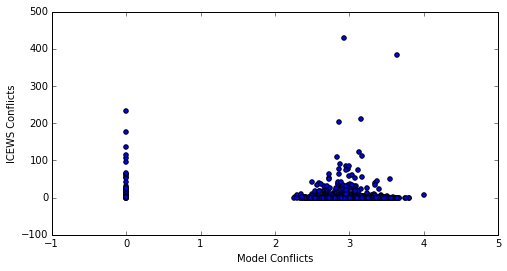

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(df.Model_Conflicts, df.ICEWS_Count)
ax.set_xlabel("Model Conflicts")
ax.set_ylabel("ICEWS Conflicts")
#ax.set_xlim(-5, 100)

In [15]:
df.corr()

,Model_Conflicts,Models_with_Conflicts,ICEWS_Count
Model_Conflicts,1.000000,0.906016,-0.181811
Models_with_Conflicts,0.906016,1.000000,-0.218725
ICEWS_Count,-0.181811,-0.218725,1.000000


In [16]:
df.corr(method="spearman")

,Model_Conflicts,Models_with_Conflicts,ICEWS_Count
Model_Conflicts,1.000000,0.561537,-0.085073
Models_with_Conflicts,0.561537,1.000000,-0.083137
ICEWS_Count,-0.085073,-0.083137,1.000000


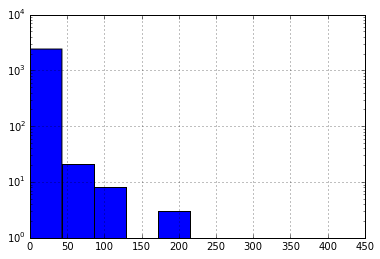

In [17]:
df.ICEWS_Count.hist()
plt.yscale('log')

In [18]:
import statsmodels.api as sm
import statsmodels
from statsmodels.discrete.discrete_model import NegativeBinomial
from statsmodels.discrete.discrete_model import Poisson
from statsmodels.miscmodels.count import PoissonZiGMLE

In [19]:
df["Const."] = 1

In [20]:
lm = sm.OLS(df["ICEWS_Count"], df[["Const.", "Model_Conflicts"]])
fit = lm.fit()

In [ ]:
print(fit.summary())

In [ ]:
nb = NegativeBinomial(df["ICEWS_Count"], df[["Const.", "Model_Conflicts"]])
fit = nb.fit()
print(fit.summary())

In [ ]:
ps = Poisson(df["ICEWS_Count"], df[["Const.", "Model_Conflicts"]])
fit = ps.fit_regularized()
print(fit.summary())

In [21]:
df["ICEWS_Dummy"] = 0
df.loc[df.ICEWS_Count>0, "ICEWS_Dummy"] = 1

In [23]:
logit = sm.Logit(df.ICEWS_Dummy, df[["Const.", "Model_Conflicts"]]).fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.527016
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            ICEWS_Dummy   No. Observations:                 2450
Model:                          Logit   Df Residuals:                     2448
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Feb 2016   Pseudo R-squ.:                 0.03535
Time:                        17:42:00   Log-Likelihood:                -1291.2
converged:                       True   LL-Null:                       -1338.5
                                        LLR p-value:                 2.287e-22
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Const.              1.4660      0.314      4.670      0.000         0.851     2.081
Model_Conflict

### Is it better than just using $\Delta$Taus?

In [ ]:
dyad_taus = {}
for i, row in df.iterrows():
    source = row.Source_Country
    target = row.Target_Country
    tau = get_tau(source, target)
    dyad_taus[(source, target)] = tau

In [ ]:
taus = pd.Series(dyad_taus).reset_index()
taus.rename(columns={"level_0": "Source_Country", 
                     "level_1": "Target_Country",
                     0: "Tau"}, inplace=True)

In [ ]:
df = df.merge(taus, how='left', on=["Source_Country", "Target_Country"])

In [ ]:
df["Tau_Dummy"] = 0
df["Tau_Dummy"][df.Tau != 0] = 1

In [ ]:
lm = sm.OLS(df["ICEWS_Count"], df[["Const.", "Tau"]])
fit = lm.fit()
print(fit.summary())

In [ ]:
logit = sm.Logit(df["ICEWS_Dummy"], df[["Const.", "Tau_Dummy", "Tau"]])
fit = logit.fit()
print(fit.summary())

In [ ]:
logit = sm.Logit(df["ICEWS_Dummy"], df[["Const.", "Tau", "Model_Conflicts"]])
fit = logit.fit()
print(fit.summary())

In [ ]:
ps = Poisson(df["ICEWS_Count"], df[["Const.", "Tau", "Model_Conflicts"]])
fit = ps.fit_regularized()
print(fit.summary())